In [776]:
import os
import sys
import random
import json
import collections
import itertools

import pandas as pd
import numpy as np
import scipy        
import statsmodels
from sklearn.model_selection import train_test_split

from tqdm import trange, tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns

import pickle
import torch
import torchtext
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import time
import torch.optim as optim
from torchtext.data import Field
from torchtext.data import Dataset, TabularDataset
from torchtext.data import Iterator

from annoy import AnnoyIndex

from MulticoreTSNE import MulticoreTSNE as TSNE

%matplotlib inline

pd.options.display.max_columns = 999

sns.set()

plt.rcParams["figure.figsize"] = (10,7)

In [777]:
os.getcwd()

'/home/boris/study/UT study/ACM Sigmod/sigmod/notebooks'

In [778]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [779]:
from sigmod_src.utils import read_json, pprint_json, path_from_spec_id, get_vector_for_spec_id
from sigmod_src.data.embedding import Embedder, EmbeddingBagEmbedder, get_fields

# Load data

In [780]:
MED_LABELS_PATH = '../data/raw/sigmod_medium_labelled_dataset.csv'
LG_LABELS_PATH = '../data/interim/large_labelled_dataset_disjoint.csv'

In [781]:
med_labels_df = pd.read_csv(MED_LABELS_PATH)
lg_labels_df = pd.read_csv(LG_LABELS_PATH)

In [782]:
med_labels_df.shape, lg_labels_df.shape

((46665, 3), (250986, 3))

In [783]:
med_labels_df.head()

,left_spec_id,right_spec_id,label
0,www.garricks.com.au//31,www.ebay.com//53278,1
1,www.ebay.com//58782,www.ebay.com//24817,0
2,www.ebay.com//58782,www.ebay.com//43019,0
3,www.ebay.com//42055,www.ebay.com//54403,0
4,www.ebay.com//44280,buy.net//6145,0


In [784]:
lg_labels_df.head()

,left_spec_id,right_spec_id,label
0,www.pricedekho.com//1053,www.ebay.com//58716,1.0
1,www.ebay.com//60064,www.ebay.com//54572,1.0
2,www.ebay.com//47074,www.ebay.com//55373,1.0
3,www.ebay.com//48188,www.ebay.com//44391,1.0
4,www.ebay.com//54736,www.ebay.com//58806,1.0


# Load specs df

In [785]:
specs_df = pd.read_csv('../data/processed/specs_preprocessed.csv')
# specs_df.index=  specs_df.spec_id
specs_df.shape

(29771, 7)

In [786]:
specs_df[specs_df.page_title.isnull()]

,spec_id,page_title,all_text,page_title_stem,all_text_stem,brand,site


In [787]:
specs_df.head()

,spec_id,page_title,all_text,page_title_stem,all_text_stem,brand,site
0,www.ebay.com//57656,canon powershot elph 110 hs 16 1 mp,canon powershot elph 110 hs 16 1 mp canon manu...,canon powershot elph 110 hs 16 1 mp,canon powershot elph 110 hs 16 1 mp canon manu...,canon,www.ebay.com
1,www.ebay.com//60583,canon rebel 2000 35 mm great case instruction ...,canon rebel 2000 35 mm great case instruction ...,canon rebel 2000 35 mm great case instruct boo...,canon rebel 2000 35 mm great case instruct boo...,canon,www.ebay.com
2,www.ebay.com//60440,canon eos rebel t3i 18 55mm 75 300mm iii lens ...,canon eos rebel t3i 18 55mm 75 300mm iii lens ...,canon eo rebel t3i 18 55mm 75 300mm iii len ki...,canon eo rebel t3i 18 55mm 75 300mm iii len ki...,canon,www.ebay.com
3,www.ebay.com//24139,ge c1033 10 1 mp 3x zoom 2 4 lcd,ge c1033 10 1 mp 3x zoom 2 4 lcd ge unused uno...,ge c1033 10 1 mp 3x zoom 2 4 lcd,ge c1033 10 1 mp 3x zoom 2 4 lcd ge unus unope...,NaN,www.ebay.com
4,www.ebay.com//54903,vivitar clip shot 1 1 mp,vivitar clip shot 1 1 mp vivitar unused unopen...,vivitar clip shot 1 1 mp,vivitar clip shot 1 1 mp vivitar unus unopen u...,vivitar,www.ebay.com


# Classes df

In [788]:
classes_df = pd.read_csv('../data/interim/classes.csv')
classes_df.head()

,spec_id,class_
0,buy.net//5641,0
1,www.ebay.com//58588,0
2,www.gosale.com//849,0
3,www.price-hunt.com//9794,0
4,buy.net//5698,1


In [789]:
classes_df.shape

(908, 2)

In [790]:
classes_df.class_.value_counts()

6     178
2     130
11     95
4      91
13     80
7      78
9      57
1      55
12     16
24     14
10     14
19     11
20      9
5       9
23      9
3       9
17      7
0       6
14      5
16      5
18      5
15      4
21      4
26      4
25      3
28      2
8       2
22      2
27      2
29      2
Name: class_, dtype: int64

## Add classes to specs

In [791]:
specs_df = specs_df.merge(classes_df, how='left')
specs_df.head()

,spec_id,page_title,all_text,page_title_stem,all_text_stem,brand,site,class_
0,www.ebay.com//57656,canon powershot elph 110 hs 16 1 mp,canon powershot elph 110 hs 16 1 mp canon manu...,canon powershot elph 110 hs 16 1 mp,canon powershot elph 110 hs 16 1 mp canon manu...,canon,www.ebay.com,NaN
1,www.ebay.com//60583,canon rebel 2000 35 mm great case instruction ...,canon rebel 2000 35 mm great case instruction ...,canon rebel 2000 35 mm great case instruct boo...,canon rebel 2000 35 mm great case instruct boo...,canon,www.ebay.com,NaN
2,www.ebay.com//60440,canon eos rebel t3i 18 55mm 75 300mm iii lens ...,canon eos rebel t3i 18 55mm 75 300mm iii lens ...,canon eo rebel t3i 18 55mm 75 300mm iii len ki...,canon eo rebel t3i 18 55mm 75 300mm iii len ki...,canon,www.ebay.com,NaN
3,www.ebay.com//24139,ge c1033 10 1 mp 3x zoom 2 4 lcd,ge c1033 10 1 mp 3x zoom 2 4 lcd ge unused uno...,ge c1033 10 1 mp 3x zoom 2 4 lcd,ge c1033 10 1 mp 3x zoom 2 4 lcd ge unus unope...,NaN,www.ebay.com,NaN
4,www.ebay.com//54903,vivitar clip shot 1 1 mp,vivitar clip shot 1 1 mp vivitar unused unopen...,vivitar clip shot 1 1 mp,vivitar clip shot 1 1 mp vivitar unus unopen u...,vivitar,www.ebay.com,NaN


In [792]:
class_vcounts = specs_df.class_.value_counts()
class_vcounts

6.0     178
2.0     130
11.0     95
4.0      91
13.0     80
7.0      78
9.0      57
1.0      55
12.0     16
10.0     14
24.0     14
19.0     11
5.0       9
20.0      9
3.0       9
23.0      9
17.0      7
0.0       6
16.0      5
14.0      5
18.0      5
26.0      4
21.0      4
15.0      4
25.0      3
8.0       2
22.0      2
28.0      2
27.0      2
29.0      2
Name: class_, dtype: int64

In [793]:
bad_classes = list(class_vcounts[class_vcounts<2].index)
bad_classes

[]

In [794]:
specs_df.shape

(29771, 8)

In [795]:
specs_df = specs_df[~specs_df.class_.isin(bad_classes)]
specs_df.shape

(29771, 8)

In [796]:
labelled_specs_df = specs_df[~specs_df.class_.isnull()].copy()
labelled_specs_df.shape

(908, 8)

In [797]:
labelled_specs_df.to_csv('../data/interim/specs_df_labelled.csv', index=None)

# Triplet generator

In [798]:
labelled_specs_df['spec_idx'] = range(len(labelled_specs_df))
labelled_specs_df.head()

,spec_id,page_title,all_text,page_title_stem,all_text_stem,brand,site,class_,spec_idx
29,www.ebay.com//55555,nikon d800 36 3 mp body,nikon d800 36 3 mp body nikon previously may s...,nikon d800 36 3 mp bodi,nikon d800 36 3 mp bodi nikon previous may sig...,nikon,www.ebay.com,13.0,0
40,www.ebay.com//46983,nikon d90 12 3 mp kit w vr 18 105 mm lens,nikon d90 12 3 mp kit w vr 18 105 mm lens niko...,nikon d90 12 3 mp kit w vr 18 105 mm len,nikon d90 12 3 mp kit w vr 18 105 mm len nikon...,nikon,www.ebay.com,4.0,1
45,www.ebay.com//55066,nikon d90 12 3 mp w af 18 200mm lens,nikon d90 12 3 mp w af 18 200mm lens nikon len...,nikon d90 12 3 mp w af 18 200mm len,nikon d90 12 3 mp w af 18 200mm len nikon len ...,nikon,www.ebay.com,4.0,2
46,www.ebay.com//41954,canon eos 20d 8 2 mp body,canon eos 20d 8 2 mp body canon extra battery ...,canon eo 20d 8 2 mp bodi,canon eo 20d 8 2 mp bodi canon extra batteri m...,canon,www.ebay.com,10.0,3
56,www.ebay.com//45818,canon eos 5d mark ii excellent japan 2882,canon eos 5d mark ii excellent japan never min...,canon eo 5d mark ii excel japan 2882,canon eo 5d mark ii excel japan never minim si...,canon,www.ebay.com,11.0,4


# Obtain train/val split

In [830]:
INTERIM_PATH = '../data/interim/'
TRAIN_PATH = 'specs_train.csv'
VAL_PATH = 'specs_val.csv'

classes = labelled_specs_df.class_.unique()
val_classes = np.random.choice(classes, 5)

labelled_specs_train = labelled_specs_df[~labelled_specs_df.class_.isin(val_classes)]
labelled_specs_val = labelled_specs_df[labelled_specs_df.class_.isin(val_classes)]

labelled_specs_train.to_csv(os.path.join(INTERIM_PATH, TRAIN_PATH), index=None)
labelled_specs_val.to_csv(os.path.join(INTERIM_PATH, VAL_PATH), index=None)

labelled_specs_train.shape, labelled_specs_val.shape

((784, 9), (124, 9))

In [831]:
text_field = get_fields()

In [832]:
%%time
datafields = [("spec_id", None),
              ("page_title", None),
              ("all_text", None),
              ("page_title_stem", text_field),
              ("all_text_stem", text_field),
                  ("brand", None),
                  ("site", None),
             ('class_', None)]

full_dataset = TabularDataset.splits(
        path="../data/processed/", # the root directory where the data lies
        train='specs_preprocessed.csv',
        format='csv',
        skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
        fields=datafields)

train_dataset, val_dataset = TabularDataset.splits(
    path=INTERIM_PATH, # the root directory where the data lies
    train=TRAIN_PATH,
    test=VAL_PATH,
    format='csv',
    skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
    fields=datafields)

full_dataset = full_dataset[0]

CPU times: user 1.86 s, sys: 31 ms, total: 1.89 s
Wall time: 1.89 s


In [833]:
train_labelled_df = pd.read_csv(os.path.join(INTERIM_PATH, TRAIN_PATH))
train_labelled_df['spec_idx'] = range(len(train_labelled_df))

train_class_lookup = train_labelled_df[~train_labelled_df.class_.isnull()].set_index('spec_idx').to_dict()['class_']
train_spec_lookup = train_labelled_df.groupby(['class_'])['spec_idx'].agg(list).to_dict()

In [834]:
val_labelled_df = pd.read_csv(os.path.join(INTERIM_PATH, VAL_PATH))
val_labelled_df['spec_idx'] = range(len(val_labelled_df))

val_class_lookup = val_labelled_df[~val_labelled_df.class_.isnull()].set_index('spec_idx').to_dict()['class_']
val_spec_lookup = val_labelled_df.groupby(['class_'])['spec_idx'].agg(list).to_dict()

In [835]:
%%time
text_field.build_vocab(full_dataset)

CPU times: user 539 ms, sys: 0 ns, total: 539 ms
Wall time: 538 ms


## Quick checks

In [836]:
specs_df.head(1)

,spec_id,page_title,all_text,page_title_stem,all_text_stem,brand,site,class_
0,www.ebay.com//57656,canon powershot elph 110 hs 16 1 mp,canon powershot elph 110 hs 16 1 mp canon manu...,canon powershot elph 110 hs 16 1 mp,canon powershot elph 110 hs 16 1 mp canon manu...,canon,www.ebay.com,NaN


In [837]:
full_dataset.examples[0].__dict__

{'all_text_stem': ['canon',
  'powershot',
  'elph',
  '110',
  'hs',
  '16',
  '1',
  'mp',
  'canon',
  'manufactur',
  'refurbish',
  'profession',
  'restor',
  'work',
  'order',
  'manufactur',
  'vendor',
  'mean',
  'inspect',
  'clean',
  'repair',
  'meet',
  'manufactur',
  'specif',
  'excel',
  'may',
  'may',
  'origin',
  'packag',
  'seller',
  'full',
  'detail',
  'open',
  'window',
  'tab',
  'read',
  'moreabout',
  'mp',
  'elph',
  '110',
  'hs',
  'e262121',
  'point',
  'shoot'],
 'page_title_stem': ['canon',
  'powershot',
  'elph',
  '110',
  'hs',
  '16',
  '1',
  'mp']}

In [838]:
train_labelled_df.head(1)

,spec_id,page_title,all_text,page_title_stem,all_text_stem,brand,site,class_,spec_idx
0,www.ebay.com//55555,nikon d800 36 3 mp body,nikon d800 36 3 mp body nikon previously may s...,nikon d800 36 3 mp bodi,nikon d800 36 3 mp bodi nikon previous may sig...,nikon,www.ebay.com,13.0,0


In [839]:
train_dataset.examples[0].__dict__

{'all_text_stem': ['nikon',
  'd800',
  '36',
  '3',
  'mp',
  'bodi',
  'nikon',
  'previous',
  'may',
  'sign',
  'cosmet',
  'wear',
  'fulli',
  'oper',
  'function',
  'intend',
  'may',
  'floor',
  'model',
  'store',
  'return',
  'seller',
  'full',
  'detail',
  'descript',
  'imperfect',
  'open',
  'window',
  'tab',
  'read',
  'moreabout',
  'mp',
  'd800',
  '25480'],
 'page_title_stem': ['nikon', 'd800', '36', '3', 'mp', 'bodi']}

In [840]:
val_labelled_df.head(1)

,spec_id,page_title,all_text,page_title_stem,all_text_stem,brand,site,class_,spec_idx
0,www.ebay.com//45818,canon eos 5d mark ii excellent japan 2882,canon eos 5d mark ii excellent japan never min...,canon eo 5d mark ii excel japan 2882,canon eo 5d mark ii excel japan never minim si...,canon,www.ebay.com,11.0,0


In [841]:
val_dataset.examples[0].__dict__

{'all_text_stem': ['canon',
  'eo',
  '5d',
  'mark',
  'ii',
  'excel',
  'japan',
  'never',
  'minim',
  'sign',
  'use',
  'canon',
  'strap',
  'neck',
  'wrist',
  'work',
  'okay',
  'heavi',
  'sign',
  'use',
  'previous',
  'may',
  'sign',
  'cosmet',
  'wear',
  'fulli',
  'oper',
  'function',
  'intend',
  'may',
  'floor',
  'model',
  'store',
  'return',
  'seller',
  'full',
  'detail',
  'descript',
  'imperfect',
  'open',
  'window',
  'tab',
  'read',
  'moreabout',
  'japan',
  'restor',
  'requir',
  'part',
  'may',
  'broken',
  'miss',
  'mp',
  '5d',
  'mark',
  'ii',
  '2764b003',
  '3'],
 'page_title_stem': ['canon',
  'eo',
  '5d',
  'mark',
  'ii',
  'excel',
  'japan',
  '2882']}

# Triplet iterator

In [842]:
def gen_triplet(anchor_id, class_lookup, id_lookup):

    anchor_class = class_lookup[anchor_id]
    positive_id = random.choice(list(set(id_lookup[anchor_class]).difference(set([anchor_id]))))

    negative_class = random.choice(list(set(id_lookup.keys()).difference([anchor_class])))
    negative_id = random.choice(id_lookup[negative_class])

    return (anchor_id, positive_id, negative_id)

def triplet_iterator(dataset,
                     class_lookup, 
                     spec_lookup,
                     batch_size=1,
                     field='all_text_stem'):
    shuffled_idx = np.arange(len(dataset))
    np.random.shuffle(shuffled_idx)
    
    num_drop = len(shuffled_idx) % batch_size
    shuffled_idx = shuffled_idx[:-num_drop] if num_drop != 0 else shuffled_idx
    shuffled_idx = shuffled_idx.reshape(-1, batch_size)
    for idxs in shuffled_idx:
        list_triplets = []
        for i in idxs:
            _, pos_idx, neg_idx = gen_triplet(i, class_lookup, spec_lookup)
            list_triplets.extend([getattr(dataset[i], field), 
                                  getattr(dataset[pos_idx], field),
                                  getattr(dataset[neg_idx], field)])
        #паддим все к одному размеру
        triplet = text_field.pad(list_triplets)
        triplet = text_field.numericalize(triplet)
        yield triplet

In [843]:
(train_dataset[gen_triplet(0, train_class_lookup, train_spec_lookup)[0]].__dict__, 
train_dataset[gen_triplet(0, train_class_lookup, train_spec_lookup)[1]].__dict__,
train_dataset[gen_triplet(0, train_class_lookup, train_spec_lookup)[2]].__dict__)

({'all_text_stem': ['nikon',
   'd800',
   '36',
   '3',
   'mp',
   'bodi',
   'nikon',
   'previous',
   'may',
   'sign',
   'cosmet',
   'wear',
   'fulli',
   'oper',
   'function',
   'intend',
   'may',
   'floor',
   'model',
   'store',
   'return',
   'seller',
   'full',
   'detail',
   'descript',
   'imperfect',
   'open',
   'window',
   'tab',
   'read',
   'moreabout',
   'mp',
   'd800',
   '25480'],
  'page_title_stem': ['nikon', 'd800', '36', '3', 'mp', 'bodi']},
 {'all_text_stem': ['nikon',
   'd800',
   '36',
   '3',
   'mp',
   'cmos',
   'fx',
   'format',
   'great',
   '23477',
   'nikon',
   'previous',
   'may',
   'sign',
   'cosmet',
   'wear',
   'fulli',
   'oper',
   'function',
   'intend',
   'may',
   'floor',
   'model',
   'store',
   'return',
   'seller',
   'full',
   'detail',
   'descript',
   'imperfect',
   'open',
   'window',
   'tab',
   'read',
   'moreabout',
   'mp',
   'd800',
   '25480'],
  'page_title_stem': ['nikon',
   'd800',
   '

In [844]:
(val_dataset[gen_triplet(0, val_class_lookup, val_spec_lookup)[0]].__dict__, 
val_dataset[gen_triplet(0, val_class_lookup, val_spec_lookup)[1]].__dict__,
val_dataset[gen_triplet(0, val_class_lookup, val_spec_lookup)[2]].__dict__)

({'all_text_stem': ['canon',
   'eo',
   '5d',
   'mark',
   'ii',
   'excel',
   'japan',
   'never',
   'minim',
   'sign',
   'use',
   'canon',
   'strap',
   'neck',
   'wrist',
   'work',
   'okay',
   'heavi',
   'sign',
   'use',
   'previous',
   'may',
   'sign',
   'cosmet',
   'wear',
   'fulli',
   'oper',
   'function',
   'intend',
   'may',
   'floor',
   'model',
   'store',
   'return',
   'seller',
   'full',
   'detail',
   'descript',
   'imperfect',
   'open',
   'window',
   'tab',
   'read',
   'moreabout',
   'japan',
   'restor',
   'requir',
   'part',
   'may',
   'broken',
   'miss',
   'mp',
   '5d',
   'mark',
   'ii',
   '2764b003',
   '3'],
  'page_title_stem': ['canon',
   'eo',
   '5d',
   'mark',
   'ii',
   'excel',
   'japan',
   '2882']},
 {'all_text_stem': ['canon',
   'eo',
   '5d',
   'mark',
   'ii',
   '21',
   '1',
   'mp',
   'kit',
   'w',
   'ef',
   'l',
   'usm',
   'canon',
   'case',
   'bag',
   'len',
   'len',
   'filter',
   'memo

In [845]:
next(iter(triplet_iterator(train_dataset, train_class_lookup, train_spec_lookup, 1)))

tensor([[ 591,    6,   10],
        [   6,   68,   99],
        [  68,  607, 2065],
        [ 607,   97,  205],
        [ 198,   21,   10],
        [   8,    2,   65],
        [2058,   71,   15],
        [  56,    6,   60],
        [ 270,   66,   73],
        [ 493,   54,   61],
        [   6,  151,   58],
        [ 155,  210,   37],
        [ 220,  208,   41],
        [ 225,    2,   62],
        [ 122,  607,   15],
        [  14, 2145,   74],
        [  14,   17,   53],
        [ 203,    1,   36],
        [  14,    1,   59],
        [ 214,    1,   28],
        [ 209,    1,   13],
        [  36,    1,   16],
        [ 221,    1,   38],
        [ 224,    1,   64],
        [  14,    1,   29],
        [ 120,    1,   22],
        [  14,    1,   32],
        [ 226,    1,   30],
        [ 132,    1,   33],
        [ 172,    1, 2065],
        [  12,    1,   39],
        [  28,    1,    1],
        [  13,    1,    1],
        [  16,    1,    1],
        [  29,    1,    1],
        [  22,    1,

In [846]:
next(iter(triplet_iterator(val_dataset, val_class_lookup, val_spec_lookup, 1)))

tensor([[   6,    6,    6],
        [  68,   68,   68],
        [ 579,  579, 4945],
        [ 377,  377,  185],
        [ 294,  294,   80],
        [ 992,  992,  399],
        [   5,  558, 7887],
        [   2,   71,   18],
        [  71,  564,   17],
        [   6,  219,  369],
        [ 206,   13,   38],
        [  70, 1757,    6],
        [  66, 1291,   68],
        [  54,    6, 4945],
        [ 151,  354,   71],
        [ 210,   36,    6],
        [ 208, 1931, 4945],
        [   2,  354,   71],
        [ 579, 1253,  424],
        [ 377,  354, 1596],
        [ 294, 1144,    6],
        [1935,  162,   69],
        [  17,  461,    6],
        [   1,  354, 4945],
        [   1, 1542,   71],
        [   1, 1637,  625],
        [   1,   65,  500],
        [   1,   15,  315],
        [   1,   60,  886],
        [   1,   73,   48],
        [   1,   61,   55],
        [   1,   58,  129],
        [   1,   37,   43],
        [   1,   41,   44],
        [   1,   62,  117],
        [   1,   15,

## Initialize NN Model

In [847]:
emb_dim = 150
hidden_dim = 300
num_linear = 4
model = EmbeddingBagEmbedder(text_field,
                     hidden_dim, emb_dim=emb_dim, num_linear=num_linear, num_lstm=num_lstm)

model

EmbeddingBagEmbedder(
  (relu): ReLU()
  (embedding_bag): EmbeddingBag(15407, 300, mode=mean)
  (linear_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=300, out_features=300, bias=True)
      (1): Dropout(p=0.05, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=300, out_features=300, bias=True)
      (1): Dropout(p=0.05, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=300, out_features=300, bias=True)
      (1): Dropout(p=0.05, inplace=False)
    )
    (3): Sequential(
      (0): Linear(in_features=300, out_features=300, bias=True)
      (1): Dropout(p=0.05, inplace=False)
    )
    (4): Sequential(
      (0): Linear(in_features=300, out_features=150, bias=True)
    )
  )
)

In [848]:
model.infer(['canon eos 20d 8 2 mp', 'nikon eos 20d 8 2 mp'])

tensor([[0.0094, 0.0733, 0.0000, 0.0094, 0.0041, 0.0332, 0.0388, 0.0162, 0.0098,
         0.0000, 0.0299, 0.0518, 0.0065, 0.0000, 0.0083, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0019, 0.0000, 0.0773, 0.0504, 0.0000, 0.0298,
         0.0000, 0.0026, 0.0065, 0.0212, 0.0000, 0.0000, 0.0016, 0.0000, 0.0317,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0275, 0.0000, 0.0000, 0.0389, 0.0180,
         0.0804, 0.0000, 0.0000, 0.0037, 0.0611, 0.0000, 0.0000, 0.0396, 0.0254,
         0.0306, 0.0000, 0.0380, 0.0274, 0.0000, 0.0000, 0.0307, 0.0000, 0.0000,
         0.0630, 0.0631, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0002, 0.0141,
         0.0143, 0.0139, 0.0000, 0.0447, 0.0504, 0.0000, 0.0307, 0.0162, 0.0000,
         0.0184, 0.0000, 0.0000, 0.0000, 0.0612, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0335, 0.0588, 0.0000, 0.0801, 0.0214, 0.0000, 0.0344, 0.0424,
         0.0000, 0.0299, 0.0000, 0.0414, 0.0489, 0.0000, 0.0440, 0.0450, 0.0000,
         0.0000, 0.0098, 0.0

In [849]:
loss_history_train = []
loss_history_val = []

In [869]:
opt = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', patience=3, verbose=True)
batch_size= 10
epochs = 25

In [863]:
def triplet_loss(anchor, pos, neg, margin=0.9):
    """
    Consine similarity for between anchor and positive should be >= 0.8
    
    Cosine similarity for negative should be < 0.8
    """
    pos_dist = F.cosine_similarity(anchor, pos, dim=1)
    neg_dist = F.cosine_similarity(anchor, neg, dim=1)
    
    loss_pos = torch.clamp(margin-pos_dist, min=0)
    loss_neg = torch.clamp(neg_dist-margin, min=0)
    return torch.sum(loss_pos + loss_neg)

# def triplet_loss(anchor, pos, neg, margin=0.5):
#     """
#         Triplet loss dot product
#     """
    
#     pos_dist = torch.norm(anchor-pos, 2, dim=1) 
#     neg_dist = torch.norm(anchor-neg, 2, dim=1) 
    
#     return torch.sum(torch.clamp(pos_dist-neg_dist+margin, min=0))

In [864]:
for triplet in iter(triplet_iterator(train_dataset, train_class_lookup, train_spec_lookup, batch_size=batch_size)):
    embeddings = model(triplet)
    anchors = embeddings[0::3]
    pos = embeddings[1::3]
    ng = embeddings[2::3]
    loss = triplet_loss(anchors, pos, ng)
    break
print(loss)

tensor(0.7131, grad_fn=<SumBackward0>)


# Train

In [865]:
validation_batches = []
for i in range(3):
    for triplet in iter(triplet_iterator(val_dataset, val_class_lookup, val_spec_lookup, batch_size=2)):
        validation_batches.append(triplet)
len(validation_batches)

186

In [870]:
%%time
for epoch in tqdm(range(1, epochs + 1)):
    model.train()
    
    running_loss = 0
    count_triplets = 0
    
    for triplet in iter(triplet_iterator(train_dataset, train_class_lookup, train_spec_lookup, batch_size=batch_size)):
        opt.zero_grad()
        
        embeddings = model(triplet)
        anchors = embeddings[0::3]
        pos = embeddings[1::3]
        ng = embeddings[2::3]
        loss = triplet_loss(anchors, pos, ng)
        loss.backward()
        opt.step()
        
        running_loss += loss.data
        count_triplets +=1 

    
    epoch_loss = running_loss / count_triplets
    loss_history_train.append(epoch_loss)
    print('Epoch: {}, Training Loss: {:.4f}'.format(epoch, epoch_loss))
    
    model.eval()
    val_loss = 0
    count_val = 0
    with torch.no_grad():
        for triplet in validation_batches:
            embeddings = model(triplet)
            anchors = embeddings[0::3]
            pos = embeddings[1::3]
            ng = embeddings[2::3]
            loss = triplet_loss(anchors, pos, ng)
            val_loss += loss.data
            count_val +=1 
        
        epoch_val_loss = val_loss/count_val
        loss_history_val.append(epoch_val_loss)
        print('val Loss: {:.4f}'.format(epoch_val_loss))
        
    scheduler.step(epoch_val_loss)
    
model.eval()

HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

Epoch: 1, Training Loss: 0.1996
val Loss: 0.1601
Epoch: 2, Training Loss: 0.1797
val Loss: 0.1618
Epoch: 3, Training Loss: 0.1638
val Loss: 0.1518
Epoch: 4, Training Loss: 0.1721
val Loss: 0.1419
Epoch: 5, Training Loss: 0.1744
val Loss: 0.1497
Epoch: 6, Training Loss: 0.1582
val Loss: 0.1521
Epoch: 7, Training Loss: 0.1619
val Loss: 0.1537
Epoch: 8, Training Loss: 0.1641
val Loss: 0.1487
Epoch     7: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 9, Training Loss: 0.1532
val Loss: 0.1560
Epoch: 10, Training Loss: 0.1526
val Loss: 0.1576
Epoch: 11, Training Loss: 0.1485
val Loss: 0.1601
Epoch: 12, Training Loss: 0.1452
val Loss: 0.1549
Epoch    11: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 13, Training Loss: 0.1476
val Loss: 0.1553
Epoch: 14, Training Loss: 0.1568
val Loss: 0.1553
Epoch: 15, Training Loss: 0.1561
val Loss: 0.1557
Epoch: 16, Training Loss: 0.1526
val Loss: 0.1564
Epoch    15: reducing learning rate of group 0 to 1.0000e-07.
Epoch: 17, Training Los

KeyboardInterrupt: 

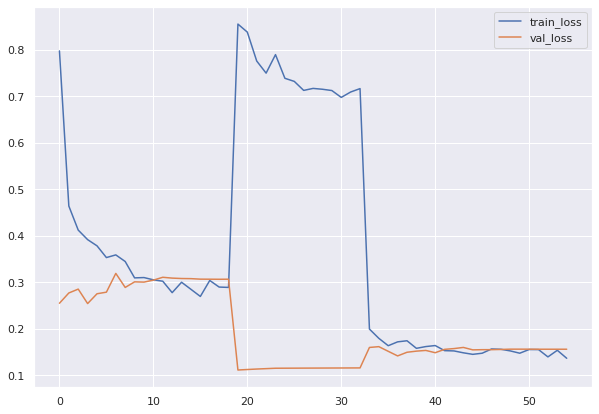

In [871]:
plt.figure()
plt.plot(loss_history_train, label='train_loss')
plt.plot(loss_history_val, label='val_loss')
plt.legend()
plt.show()

In [872]:
model.eval()

EmbeddingBagEmbedder(
  (relu): ReLU()
  (embedding_bag): EmbeddingBag(15407, 300, mode=mean)
  (linear_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=300, out_features=300, bias=True)
      (1): Dropout(p=0.05, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=300, out_features=300, bias=True)
      (1): Dropout(p=0.05, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=300, out_features=300, bias=True)
      (1): Dropout(p=0.05, inplace=False)
    )
    (3): Sequential(
      (0): Linear(in_features=300, out_features=300, bias=True)
      (1): Dropout(p=0.05, inplace=False)
    )
    (4): Sequential(
      (0): Linear(in_features=300, out_features=150, bias=True)
    )
  )
)

# Produce train embeddings and TSNE

In [873]:
from sklearn.preprocessing import normalize

In [881]:
def draw_tsne(model, dataset, df, label=''):
    embeddings = []
    for ex in tqdm(dataset):
        emb = np.array(model(model.text_field.numericalize([ex.all_text_stem]))[0].data)
        embeddings.append(emb)
    embeddings = normalize(np.array(embeddings))
    
    tsne = TSNE(
        n_components=2,
        metric='cosine',
        n_jobs=3,
        verbose=True,
    )
    
    emb_ld = tsne.fit_transform(embeddings)
    
    labelled_spec_classes = df.class_
    labelled_spec_classes = labelled_spec_classes.reset_index()
    
    emb_tdf = pd.DataFrame(emb_ld)
    emb_tdf = pd.concat([emb_tdf, labelled_spec_classes], axis=1, ignore_index=True)
    emb_tdf.columns = ['x', 'y', 'original_index', 'class_']

    
    
    plt.figure(figsize=(15, 10))
    plt.title(f'TSNE {label}')
    for class_ in emb_tdf['class_'].sort_values().unique():
        class_ld_df = emb_tdf[emb_tdf.class_==class_]
        plt.scatter(class_ld_df.iloc[:, 0], class_ld_df.iloc[:, 1], label=f'class {class_}')

    plt.legend()
    plt.show()

HBox(children=(IntProgress(value=0, max=784), HTML(value='')))

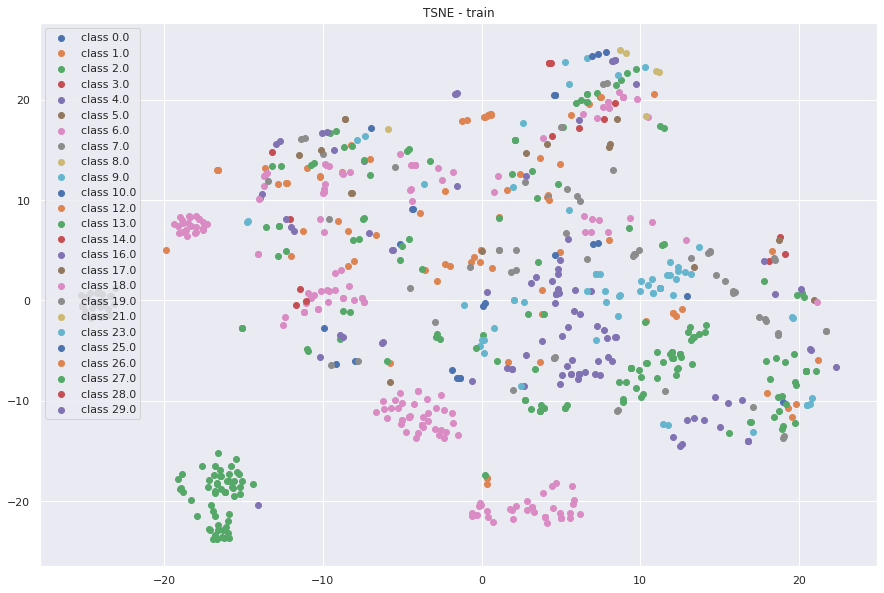

In [882]:
draw_tsne(model, train_dataset, labelled_specs_train, label ='- train')

HBox(children=(IntProgress(value=0, max=124), HTML(value='')))

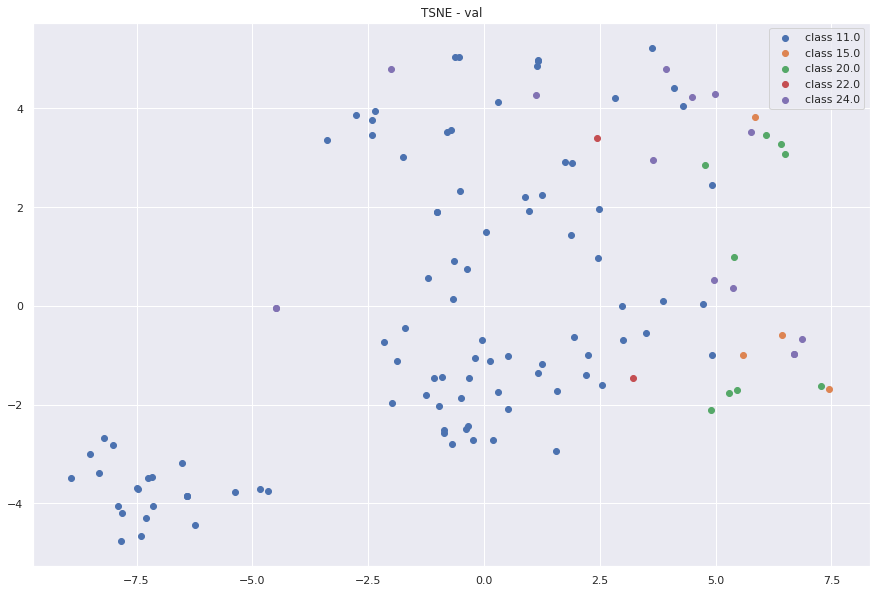

In [883]:
draw_tsne(model, val_dataset, labelled_specs_val, label ='- val')

# Produce whole dataset embeddings

In [884]:
embeddings = []
for ex in tqdm(full_dataset):
    emb = np.array(model(model.text_field.numericalize([ex.all_text_stem]))[0].data)
    embeddings.append(emb)
embeddings = normalize(np.array(embeddings))

HBox(children=(IntProgress(value=0, max=29771), HTML(value='')))

In [885]:
emb_df = pd.DataFrame(embeddings)
emb_df.to_csv('../data/processed/embeddings.csv', index=None)

In [886]:
emb_df = pd.read_csv('../data/processed/embeddings.csv')

In [887]:
emb = Embedder(model, specs_df.spec_id.values, specs_df.all_text_stem.values)

In [ ]:
emb.fit(emb_df.values)

In [ ]:
emb.lookup_texts('canon eo 20d')

In [ ]:
emb.save('../models/embedder')